Average cumulative regret: 155.14375


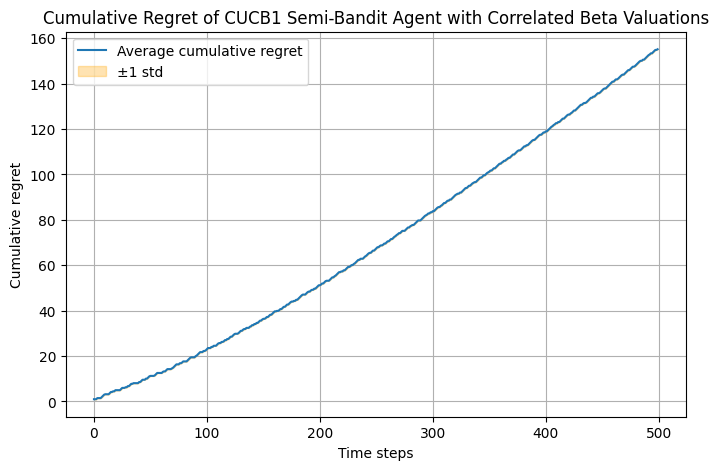

In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# -------------------------
# Environment with correlated Beta valuations
# -------------------------
class MultiProductPricingEnvironment:
    def __init__(self, costs, prices_grid, mean=None, cov=None, a=2, b=5):
        self.costs = np.asarray(costs, dtype=float)
        self.prices_grid = [np.asarray(p, dtype=float) for p in prices_grid]
        self.d = len(costs)

        self.mean = np.zeros(self.d) if mean is None else np.asarray(mean, dtype=float)
        self.cov  = 0.1*np.eye(self.d) if cov is None else np.asarray(cov, dtype=float)
        self._mvn = stats.multivariate_normal(mean=self.mean, cov=self.cov)

        # beta marginals
        self.marginals = [stats.beta(a, b) for _ in range(self.d)]

    def sample_valuations(self, n_customers):
        # Gaussian copula
        z = self._mvn.rvs(size=n_customers)
        u = stats.norm.cdf(z)  # transform to uniform marginals
        vals = np.column_stack([m.ppf(u[:, i]) for i, m in enumerate(self.marginals)])
        return vals

    def round(self, chosen_prices, n_customers=100):
        chosen_prices = np.asarray(chosen_prices, dtype=float)
        vals = self.sample_valuations(n_customers)
        d_t = (vals >= chosen_prices).astype(int).sum(axis=0)
        r_t = float(np.dot(chosen_prices - self.costs, d_t)/n_customers)
        return d_t, r_t

# -------------------------
# DP for budget-constrained pricing
# -------------------------
def choose_products_prices(values_grid, prices_grid, budget):
    d = len(values_grid)
    B = int(budget * 100)
    dp = np.zeros((d+1, B+1))
    keep = -np.ones((d, B+1), dtype=int)

    for i in range(d):
        for b in range(B+1):
            max_val = dp[i, b]
            best_j = -1
            for j, price in enumerate(prices_grid[i]):
                price_int = int(price*100)
                if price_int <= b:
                    val = values_grid[i][j] + dp[i, b - price_int]
                    if val > max_val:
                        max_val = val
                        best_j = j
            dp[i+1, b] = max_val
            keep[i, b] = best_j

    chosen_idx = [-1]*d
    b = B
    for i in reversed(range(d)):
        j = keep[i, b]
        if j >= 0:
            chosen_idx[i] = j
            b -= int(prices_grid[i][j]*100)
    return chosen_idx

# -------------------------
# Combinatorial UCB1 (semi-bandit)
# -------------------------
class CombinatorialUCB1:
    def __init__(self, prices_grid, budget, T):
        self.prices_grid = prices_grid
        self.d = len(prices_grid)
        self.budget = budget
        self.T = T

        self.counts = [np.zeros(len(g)) for g in prices_grid]
        self.values = [np.zeros(len(g)) for g in prices_grid]
        self.t = 0

    def pull_arm(self):
        self.t += 1
        ucb_scores = []
        for i in range(self.d):
            n = self.counts[i]
            v = self.values[i]
            bonus = np.sqrt(2 * np.log(max(1, self.t)) / (n + 1e-8))
            ucb = v + bonus
            ucb_scores.append(ucb)
        chosen_indices = choose_products_prices(ucb_scores, self.prices_grid, self.budget)
        self.last_indices = chosen_indices
        chosen_prices = np.array([self.prices_grid[i][idx] if idx >= 0 else 0.0
                                  for i, idx in enumerate(chosen_indices)])
        return chosen_prices

    def update(self, per_product_rewards):
        for i, idx in enumerate(self.last_indices):
            if idx >= 0:
                self.counts[i][idx] += 1
                n = self.counts[i][idx]
                self.values[i][idx] += (per_product_rewards[i] - self.values[i][idx]) / n

# -------------------------
# Simulation and regret
# -------------------------
def run_simulation(costs, prices_grid, budget, T=500, n_customers=100, n_trials=5):
    d = len(costs)
    env_for_baseline = MultiProductPricingEnvironment(costs, prices_grid)
    W = np.zeros((d, max(len(p) for p in prices_grid)))
    for i, grid in enumerate(prices_grid):
        for j, price in enumerate(grid):
            _, r = env_for_baseline.round(np.array([price if k==i else 0 for k in range(d)]), n_customers)
            W[i,j] = r
    best_indices = choose_products_prices([W[i,:len(prices_grid[i])] for i in range(d)], prices_grid, budget)
    expected_clairvoyant_reward = sum(W[i, idx] for i, idx in enumerate(best_indices) if idx>=0)

    all_regrets = []
    for trial in range(n_trials):
        env = MultiProductPricingEnvironment(costs, prices_grid)
        agent = CombinatorialUCB1(prices_grid, budget, T)
        agent_rewards = []
        for t in range(T):
            chosen_prices = agent.pull_arm()
            _, r_t = env.round(chosen_prices, n_customers)
            per_product_rewards = chosen_prices - costs
            agent.update(per_product_rewards)
            agent_rewards.append(r_t)
        agent_rewards = np.array(agent_rewards)
        cumulative_regret = np.cumsum(expected_clairvoyant_reward - agent_rewards)
        all_regrets.append(cumulative_regret)

    all_regrets = np.array(all_regrets)
    avg_regret = all_regrets.mean(axis=0)
    regret_sd = all_regrets.std(axis=0)
    return avg_regret, regret_sd

# -------------------------
# Plotting
# -------------------------
def plot_regret(avg_regret, regret_sd):
    plt.figure(figsize=(8,5))
    T = len(avg_regret)
    plt.plot(range(T), avg_regret, label="Average cumulative regret")
    plt.fill_between(range(T), avg_regret - regret_sd, avg_regret + regret_sd, color='orange', alpha=0.3, label="±1 std")
    plt.xlabel("Time steps")
    plt.ylabel("Cumulative regret")
    plt.title("Cumulative Regret of CUCB1 Semi-Bandit Agent with Correlated Beta Valuations")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    costs = [0.2, 0.3, 0.5]
    prices_grid = [
        np.linspace(0.2, 1.0, 5),
        np.linspace(0.3, 1.0, 5),
        np.linspace(0.5, 1.0, 5)
    ]
    budget = 1.5
    avg_regret, regret_sd = run_simulation(costs, prices_grid, budget, T=500, n_customers=100, n_trials=5)
    print("Average cumulative regret:", avg_regret[-1])
    plot_regret(avg_regret, regret_sd)
